In [1341]:
import pandas as pd
import seaborn as sns
import numpy as np 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import cross_val_predict

In [1342]:
url = r"..\data\raw\clean_house.csv"
house = pd.read_csv(url, sep=",")

## Functions

In [1343]:
def replace_outliers(df, columns):
    for column in columns:
    # Outliers handling
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        max_value = Q3 + (1.5 * IQR)
        min_value = Q1 - (1.5 * IQR)

        outliers_mask = (df[column] < min_value) | (df[column] > max_value)
        df.loc[outliers_mask, column] = np.nan

        df.dropna(subset=[column], inplace=True)
    return df

In [1344]:
def drop_columns(df, clist):
    ndf = df.drop(columns=clist)
    return ndf


In [1345]:
# dropping the NaN values in the columns selected
def droping_null(df, colist):
    df.dropna(subset=colist, inplace=True)
    return df

In [1346]:
def transform_categorical(df, clist):
    for column in clist:
        # One-hot encode the current column
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        X_ohe = ohe.fit_transform(df[[column]])
        
        # Convert the one-hot encoded features to a DataFrame
        ohe_df = pd.DataFrame(X_ohe, columns=ohe.get_feature_names_out())
        
        # Concatenate the original DataFrame with the one-hot encoded DataFrame
        df = pd.concat([df, ohe_df], axis=1)
        
        # Drop the original categorical column
        df.drop(columns=[column], inplace=True)

    return df

In [1347]:
def tranform_label_encoder(df, clist):
    for column in clist:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
    return df


In [1348]:
def create_X_y(df, Y):
    X = df.drop(columns=[Y])
    y = df[[Y]]
    return X, y

In [1349]:
def replace_NaN_Categorical(df, comlist):
    df[comlist] = df[comlist].fillna(0.0)

In [1350]:
def change_to_int(df, columnsname):
    for column in columnsname:
        df[column] = df[column].round().astype(int)
    return df

In [1351]:
def replace_null_median(df, columnname):
    for column in columnname:
        condition_1 = (df[column].isnull())
        df.loc[condition_1, column] = df[column].median()
    return df

In [1352]:
def replace_null_min_one(df, columnname):
    for column in columnname:
        condition_1 = (df[column].isnull())
        df.loc[condition_1, column] = -1
    return df

In [1353]:
def replace_null_mean(df, columnname):

    for column in columnname:
        condition_1 = (df[column].isnull())
        df.loc[condition_1, column] = df[column].mean()
    return df

In [1354]:
def replace_null_to_zero(df, columnname):

    for column in columnname:
        condition_1 = (df[column].isnull())
        df.loc[condition_1, column] = 0
    return df

In [1355]:
def scaling(df, cl):
    for column in cl:
        scaler = StandardScaler()
        #Fit and transform the data
        df[column] = scaler.fit_transform(df[[column]])
    return df

# code

## Single linear regression

the score is (train):0.40304835825471796
the score is (test): 0.42041877849722276
the Rscore is: 0.42041877849722276


ValueError: x and y must be the same size

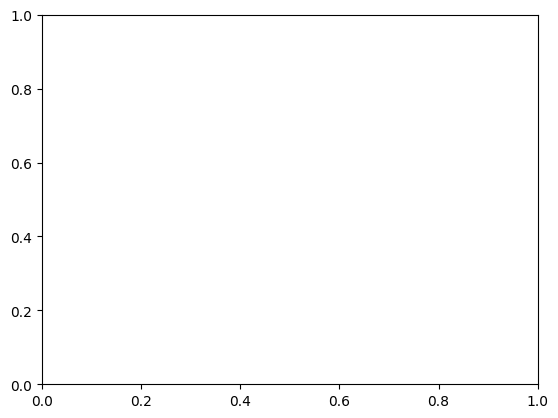

In [1356]:
# Subset the data in singel regression
house = house[["price", "surface_of_good", "garden_area","terrace_area", "province", "postal_code", "state_of_building", "property_subtype", "number_of_facades", "swimming_pool", "open_fire", "fully_equipped_kitchen"]]
#house = replace_outliers(house, ["terrace_area"])
house['postal_code'] = house['postal_code'].astype(str).str[:2]
#plt.scatter(house["terrace_area"], house["price"])
plist = ["province", "postal_code"]
clist = ["state_of_building", "property_subtype"]
house = transform_categorical(house, plist)
house = tranform_label_encoder(house, clist)
house = replace_null_min_one(house, ["price"])
#house = droping_null(house, ["price"])


X, y = create_X_y(house, "price")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=40 )
X_train = replace_null_mean(X_train, ["surface_of_good", "garden_area", "terrace_area"])
X_train = replace_null_median(X_train, ["number_of_facades"])
X_train = replace_null_to_zero(X_train, ["swimming_pool"])
columns_with_null = X_train.columns[X_train.isnull().any()].tolist()
X_train = replace_null_to_zero(X_train, columns_with_null)
#X_test = replace_null_mean(X_test, ["surface_of_good"])

X_test = replace_null_mean(X_test, ["surface_of_good", "garden_area", "terrace_area"])
X_test = replace_null_median(X_test, ["number_of_facades"])
X_test = replace_null_to_zero(X_test, ["swimming_pool"])
columns_with_null = X_test.columns[X_test.isnull().any()].tolist()
X_test = replace_null_to_zero(X_test, columns_with_null)


regressor = LinearRegression()
regressor.fit(X_train, y_train)
scoretrain = regressor.score(X_train, y_train)
scoretest = regressor.score(X_test, y_test)
y_pred = regressor.predict(X_test)
score2 = r2_score(y_test, y_pred)
print(f"the score is (train):{scoretrain}\n"
      f"the score is (test): {scoretest}\n"
      f"the Rscore is: {score2}")

plt.scatter(X_test, y_test, color ='b')

plt.plot(X_test, y_pred, color ='k')

plt.show()